
# prediccion de incidentes viales en la ciudad de Medellin

## importacion librerias necesarias

In [1]:
import pandas as pd
import re
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers


## lectura y exploracion de los datos

In [2]:
#lectura dataframe saltando las filas malas
df=pd.read_csv("incidentes_viales.csv",on_bad_lines='skip',index_col=False,sep=";",encoding="UTF-8")
print(df.head())

    AÑO  CBML CLASE_ACCIDENTE      DIRECCION       DIRECCION ENCASILLADA  \
0  2015  1013  Caida Ocupante    CR 46 CL 43    CR  046   043  000 00000   
1  2015  1020          Choque  CR 43 A CL 29  CR  043 A   029  000 00000   
2  2015  0205            Otro    CR 46 CL 37    CR  046   037  000 00000   
3  2015  0101       Atropello   CR 34 CL 112    CR  034   112  000 00000   
4  2015  1504          Choque    CR 50 CL 14    CR  050   014  000 00000   

         DISEÑO  EXPEDIENTE      FECHA_ACCIDENTE          FECHA_ACCIDENTES  \
0  Tramo de via  A000259731  21/10/2015 05:58:00  2015-10-21T10:58:00.000Z   
1  Tramo de via  A000261725  05/11/2015 03:00:00  2015-11-05T08:00:00.000Z   
2  Tramo de via  A000259739  21/10/2015 07:40:00  2015-10-21T12:40:00.000Z   
3  Tramo de via  A000259752  21/10/2015 12:00:00  2015-10-21T17:00:00.000Z   
4  Tramo de via  A000259949  03/11/2015 06:16:00  2015-11-03T11:16:00.000Z   

  GRAVEDAD_ACCIDENTE  MES NRO_RADICADO NUMCOMUNA                     BARRI

C:\Users\johan\anaconda3\envs\tensorflow_gpu\lib\site-packages\IPython\core\interactiveshell.py:3552: DtypeWarning: Columns (0,11) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [3]:
#revisamos las columnas
print(df.columns)
print("numero de columnas iniciales ",len(df.columns))
print("numero de filas iniciales ",df.shape[0])


Index(['AÑO', 'CBML', 'CLASE_ACCIDENTE', 'DIRECCION', 'DIRECCION ENCASILLADA',
       'DISEÑO', 'EXPEDIENTE', 'FECHA_ACCIDENTE', 'FECHA_ACCIDENTES',
       'GRAVEDAD_ACCIDENTE', 'MES', 'NRO_RADICADO', 'NUMCOMUNA', 'BARRIO',
       'COMUNA', 'LOCATION', 'X', 'Y'],
      dtype='object')
numero de columnas iniciales  18
numero de filas iniciales  270765


## limpieza de datos

In [4]:
#eliminacion de datos con nulos
df.dropna(inplace=True)
#eliminar datos duplicados
df.drop_duplicates(inplace=True)
print(df.shape[0])

250686


In [5]:
#AÑO-Año de ocurrencia del incidente
df["AÑO"]=df["AÑO"].apply(lambda x : re.findall(r"[0-9]{4}",str(x))[0])
print(df["AÑO"].unique())

['2015' '2014' '2016' '2017' '2018' '2019' '2020']


In [6]:
#CBML-Codigo catastral que corresponde al codigo comuna, barrio, manzana, lote catastral de un predio.
print(len(df["CBML"].unique()))

521


In [7]:
#CLASE_ACCIDENTE-Clasificación del IPAT sobre la clase de accidente de transito: choque, atropello, volcamiento,
#caida de ocupante, incendio, u otro (que no corresponde a las anteriores 5 clasificaciones, p. ej: sumersión)
df["CLASE_ACCIDENTE"]=df["CLASE_ACCIDENTE"].apply(lambda x : str(x).replace("Caída de Ocupante","Caida Ocupante").lower())
print((df["CLASE_ACCIDENTE"].unique()))

['caida ocupante' 'choque' 'otro' 'atropello' 'volcamiento' 'incendio']


In [8]:
#DIRECCION-Dirección donde ocurrió el incidente
##aparentemente se encuentra ya formateada
print((df["DIRECCION"].sample(10)))

10753        CR 52 CL 20
12132        CR 50 CL 30
109339       CR 62 CL 33
86922      CR 64 C CL 72
202053     CL 95 B CR 82
247307     CL 95 A CR 38
226685       CR 80 CL 36
105652       CR 44 CL 30
238472       CR 48 CL 10
67902     CR 110 CL 39 B
Name: DIRECCION, dtype: object


In [9]:
#DIRECCION ENCASILLADA-	Dirección encasillada que entrega el geocodificador
##aparentemente se encuentra ya formateada
##variable con poca informacion util dada la variable anterior--escoger una de las 2
print((df["DIRECCION ENCASILLADA"].sample(10)))

234187     CL  054 A   030  000 00000
66764      CR  064 AA  103  000 00000
208209      CL S 006   052  000 00000
83000        CR  052   019  000 00000
27527        CL  055   070  000 00000
233944       CL  054   030  000 00000
9215       CL  036   108 A  000 00000
228805    CL S 012 B   051  000 00000
158971       CR  039   075  000 00000
90659        CR  065   097  000 00000
Name: DIRECCION ENCASILLADA, dtype: object


In [10]:
#DISENO-Sitio de la vía donde ocurrió el accidente: Cicloruta, Glorieta, Interseccion, Lote o Predio, Paso a Nivel, Paso Elevado,
#Paso Inferior, Pontón, Puente, Tramo de via, Tunel, Via peatonal
df["DISEÑO"]=df["DISEÑO"].apply(lambda x : str(x).replace("Pont\\xF3n","Pontón").lower())
print((df["DISEÑO"].unique()))

['tramo de via' 'interseccion' 'glorieta' 'lote o predio' 'paso a nivel'
 'puente' 'paso elevado' 'ciclo ruta' 'paso inferior' 'via peatonal'
 'pontón' 'tunel']


In [11]:
#EXPEDIENTE
#Consecutivo que asigna UNE, según el orden de llegada de los expedientes para su diligenciamiento
##variable  aprarentemente con poco valor
print((df["EXPEDIENTE"].sample(10)))

228601    A000300624
57251     A000091599
23472     A000915655
139454    A000921746
184862    A000840201
263697    A001077602
151901    A000481509
161124    A000930676
63926     A001080531
45312     A000126018
Name: EXPEDIENTE, dtype: object


In [12]:
#FECHA_ACCIDENTE
#Fecha del accidente, proviene del IPAT - Informe Policial de accidente de Tránsito
df["FECHA_ACCIDENTE"] = pd.to_datetime(df["FECHA_ACCIDENTE"],dayfirst=True)
print((df["FECHA_ACCIDENTE"].sample(10)))

107018   2014-11-05 11:15:00
756      2014-10-16 12:10:00
165840   2019-07-12 17:40:00
252001   2019-03-23 12:20:00
258329   2019-08-22 15:30:00
247684   2017-11-10 05:30:00
198004   2014-09-08 08:10:00
165176   2019-06-25 16:10:00
264840   2020-01-15 14:50:00
238803   2017-05-29 12:20:00
Name: FECHA_ACCIDENTE, dtype: datetime64[ns]


In [13]:
#FECHA_ACCIDENTES
#Fecha de los accidente (formato YYYY-MM-DD hh:mi:ss), proviene del IPAT - Informe Policial de accidentes de Tránsito
##veriable redundante con la anterior
print((df["FECHA_ACCIDENTES"].head(10)))

0    2015-10-21T10:58:00.000Z
1    2015-11-05T08:00:00.000Z
2    2015-10-21T12:40:00.000Z
3    2015-10-21T17:00:00.000Z
4    2015-11-03T11:16:00.000Z
5    2015-11-05T09:30:00.000Z
6    2015-10-18T09:40:00.000Z
7    2015-11-04T09:46:00.000Z
8    2015-10-21T12:00:00.000Z
9    2015-11-05T12:00:00.000Z
Name: FECHA_ACCIDENTES, dtype: object


In [14]:
#GRAVEDAD_ACCIDENTE
#Clasificación del IPAT - Informe Policial de Accidentes de Tránsito, sobre la gravedad del accidente, corresponde al resultado 
#más grave presentado en el accidente. Daños materiales "Sólo daños", accidente con heridos "Herido", accidente con muertos 
#"Muerto". No indica cantidad
df["GRAVEDAD_ACCIDENTE"]=df["GRAVEDAD_ACCIDENTE"].apply(lambda x : str(x).replace("Solo da\\xF1os","Solo daños").lower())
print((df["GRAVEDAD_ACCIDENTE"].unique()))

['con heridos' 'solo daños' 'con muertos']


In [15]:
#MES
#Mes de ocurrencia del incidente vial
print((df["MES"].unique()))

[10 11 12  9  4  3  5  6  7  8  1  2]


In [16]:
#NRO_RADICADO
#Consecutivo que asigna UNE, según el orden de llegada de los expedientes para su diligenciamiento
#no tiene mucho valor aparentemente para nuestros fines
print((df["NRO_RADICADO"].head()))

0    1508668
1    1510621
2    1508691
3    1508694
4    1510634
Name: NRO_RADICADO, dtype: object


In [17]:
#NUMCOMUNA
#Numero de la comununa en la que ocurrio incidente vial
#se eliminan las filas con valores que no corespondan con 
df=df[df["NUMCOMUNA"]!="AU"]
df=df[df["NUMCOMUNA"]!="Sin Inf"]
df=df[df["NUMCOMUNA"]!="In"]
df=df[df["NUMCOMUNA"]!="SN"]
df=df[df["NUMCOMUNA"]!="0"]
#asuminos que las comunas 60,70,80,90 son las comunas 6,7,8,9 respectivamente
df["NUMCOMUNA"]=df["NUMCOMUNA"].apply(lambda x : (int(x)))
df["NUMCOMUNA"]=df["NUMCOMUNA"].apply(lambda x : x/10 if x >20 else x)
df["NUMCOMUNA"]=df["NUMCOMUNA"].apply(lambda x : str(int(x)))
print(sorted(df["NUMCOMUNA"].unique()))

['1', '10', '11', '12', '13', '14', '15', '16', '2', '3', '4', '5', '6', '7', '8', '9']


In [18]:
#BARRIO
print(len(df["BARRIO"].unique()))
#Barrio de ocurrencia del incidente vial
#ó por o
df["BARRIO"]=df["BARRIO"].apply(lambda x : str(x).lower().replace("\\xf3","o").replace("ó","o"))
#é por e 
df["BARRIO"]=df["BARRIO"].apply(lambda x : str(x).replace("\\xe9","e").replace("é","e"))
#á por a 
df["BARRIO"]=df["BARRIO"].apply(lambda x : str(x).replace("\\xc1","a").replace("\\xe1","a").replace("á","a"))
#ñ
df["BARRIO"]=df["BARRIO"].apply(lambda x : str(x).replace("\\xf1","ñ"))
#\\xed í por i
df["BARRIO"]=df["BARRIO"].apply(lambda x : str(x).replace("\\xed","i").replace("í","i"))
#\\xfa ú por u
df["BARRIO"]=df["BARRIO"].apply(lambda x : str(x).replace("\\xfa","u").replace("ú","u"))
print((df["BARRIO"].unique()))

488
['barrio colon' 'san diego' 'la francia' 'santo domingo savio no. 1'
 'santa fe' 'la florida' 'los conquistadores' 'la alpujarra' 'villa nueva'
 'facultad de minas u. nacional' 'la esperanza' 'perpetuo socorro'
 'campo valdes no. 1' 'miraflores' 'oleoducto' 'terminal de transporte'
 'gerona' 'u.d. atanasio girardot' 'alejandro echavarria'
 'cabecera san antonio de prado' 'manila' 'los balsos no.2' 'moravia'
 'tenche' 'universidad nacional' 'los colores' 'caribe'
 'juan xxiii la quiebra' 'belalcazar' 'santa cruz' 'sucre' 'la candelaria'
 'el estadio' 'suramericana' 'la gloria' 'centro administrativo'
 'las estancias' 'aures no. 2' 'los angeles' 'castilla' 'la salle'
 'la america' 'picacho' 'bosques de san pablo' 'la aguacatala'
 'playon de los comuneros' 'estacion villa' 'la colina' 'popular'
 'villa del socorro' 'cucaracho' 'santa maria de los angeles'
 'el chagualo' 'la mansion' 'san benito' 'la castellana' 'jesus nazareno'
 'loreto' 'asomadera no. 1' 'el salvador' 'cristo rey' 'm

In [19]:
#COMUNA
#Denominación con la cual se identifica cada Comuna o Corregimiento. 01:Popular 02:Santa Cruz 03:Manrique 04:Aranjuez 05:Castilla 06:Doce de Octubre 07:Robledo 08:Villa Hermosa 09:Buenos Aires 10:La Candelaria 11:Laureles - Estadio 12:La América 13:San Javier 14:El Poblado 15:Guayabal 16:Belén 50:San Sebastián de Palmitas 60:San Cristobal 70:Altavista 80:San Antonio de Prado 90:Santa Elena 99:Toda la Ciudad
##variable redundante
#ó por o
df["COMUNA"]=df["COMUNA"].apply(lambda x : str(x).lower().replace("\\xf3","o").replace("ó","o"))
#á por a 
df["COMUNA"]=df["COMUNA"].apply(lambda x : str(x).replace("\\xc1","a").replace("\\xe1","a").replace("á","a"))
#é por e 
df["COMUNA"]=df["COMUNA"].apply(lambda x : str(x).replace("\\xe9","e").replace("é","e"))
print((df["COMUNA"].unique()))

['la candelaria' 'santa cruz' 'popular' 'guayabal' 'el poblado'
 'laureles estadio' 'robledo' 'doce de octubre' 'aranjuez' 'buenos aires'
 'castilla' 'corregimiento de san antonio de prado' 'san javier'
 'villa hermosa' 'belen' 'manrique' 'la america'
 'corregimiento de altavista' 'corregimiento de san cristobal'
 'corregimiento de santa elena' 'in'
 'corregimiento de san sebastian de palmitas' 'au']


In [20]:
#LOCATION
#Fuente de información con la cual se realizó la geocodificación
print((df["LOCATION"].head(10)))

0    [-75.5688011014, 6.24312304123]
1    [-75.5693883283, 6.22870030622]
2    [-75.5503911403, 6.29869502502]
3    [-75.5442195069, 6.30019383306]
4     [-75.578180998, 6.21699243701]
5      [-75.561118009, 6.2047775959]
6    [-75.5810144962, 6.24576066323]
7    [-75.5752597216, 6.24685341912]
8    [-75.5624178534, 6.25341454089]
9    [-75.5931430393, 6.27330476643]
Name: LOCATION, dtype: object


In [21]:
#X
#Coordenada X en metros del accidente, en sistema de coordenadas MAGNA Medellin Local
print(df["X"].head(10))

0    834949.69
1    834880.17
2    837004.94
3    837688.53
4    833903.11
5    835788.30
6    833598.49
7    834235.89
8    835659.53
9    832264.64
Name: X, dtype: float64


In [22]:
#Y
#Coordenada Y en metros del accidente, en sistema de coordenadas MAGNA Medellin Local
print(df["Y"].head(10))

0    1182357.34
1    1180762.02
2    1188499.17
3    1188663.05
4    1179469.60
5    1178113.02
6    1182652.97
7    1182772.04
8    1183493.83
9    1185703.90
Name: Y, dtype: float64


In [23]:
#Eliminar duplicados
df.drop_duplicates(inplace=True)
#borrar columnas con datos redudantes o poco aportantes
df.drop(labels=["DIRECCION ENCASILLADA","EXPEDIENTE","FECHA_ACCIDENTES","NRO_RADICADO","COMUNA"],axis=1,inplace=True)

In [24]:
df.to_csv("datosLimpios.csv")
#guardamos los datos en una nueva varible
data=df.copy()
df

,AÑO,CBML,CLASE_ACCIDENTE,DIRECCION,DISEÑO,FECHA_ACCIDENTE,GRAVEDAD_ACCIDENTE,MES,NUMCOMUNA,BARRIO,LOCATION,X,Y
0,2015,1013,caida ocupante,CR 46 CL 43,tramo de via,2015-10-21 05:58:00,con heridos,10,10,barrio colon,"[-75.5688011014, 6.24312304123]",834949.69,1182357.34
1,2015,1020,choque,CR 43 A CL 29,tramo de via,2015-11-05 03:00:00,solo daños,11,10,san diego,"[-75.5693883283, 6.22870030622]",834880.17,1180762.02
2,2015,0205,otro,CR 46 CL 37,tramo de via,2015-10-21 07:40:00,con heridos,10,2,la francia,"[-75.5503911403, 6.29869502502]",837004.94,1188499.17
3,2015,0101,atropello,CR 34 CL 112,tramo de via,2015-10-21 12:00:00,con heridos,10,1,santo domingo savio no. 1,"[-75.5442195069, 6.30019383306]",837688.53,1188663.05
4,2015,1504,choque,CR 50 CL 14,tramo de via,2015-11-03 06:16:00,solo daños,11,15,santa fe,"[-75.578180998, 6.21699243701]",833903.11,1179469.60
...,...,...,...,...,...,...,...,...,...,...,...,...,...
270760,2020,1004,caida ocupante,CR 62 CL 59,tramo de via,2020-08-31 18:50:00,con heridos,8,10,el chagualo,"[-75.5731343044, 6.26063534822]",834475.51,1184295.99
270761,2020,1115,otro,CL 50 CR 74,tramo de via,2020-08-31 18:50:00,con heridos,8,11,cuarta brigada,"[-75.5902062951, 6.26040455473]",832585.61,1184275.87
270762,2020,515,choque,CL 80 CR 65,tramo de via,2020-08-31 19:05:00,solo daños,8,5,cementerio universal,"[-75.5735398111, 6.27625838886]",834435.55,1186024.41
270763,2020,207,atropello,CL 104 CR 45,tramo de via,2020-08-31 19:30:00,con heridos,8,2,villa del socorro,"[-75.5515085985, 6.29359892373]",836879.66,1187935.77


In [25]:
#df=pd.read_csv("datosLimpios.csv")

## 1 - Entrenamiento de un modelo predictivo
Se deberá construir un modelo que permita predecir la accidentalidad por tipo de accidente a nivel semanal, mensual y diario. Para esto se deberán considerar fechas especiales.

vamos a suponer que para los dias que no hay registro de algun tipo de accidente, el numero de accidentes de este tipo para este dia es 0

In [26]:
#creamos un dataframe con todos las posibles combinaciones de dia, en tre el rango de fechas,
from datetime import datetime, timedelta
inicio = datetime(2014,7,4)
fin    = datetime(2020,8,31)

df_aux = pd.DataFrame([inicio + timedelta(days=d) for d in range((fin - inicio).days + 1)],columns=["DIA"])
df_aux["DIA"]=df_aux["DIA"].apply(lambda x : str(x)[:10])
df_aux["key"]=1
clase_accidente=pd.DataFrame(df.CLASE_ACCIDENTE.unique(),columns=["CLASE_ACCIDENTE"])
clase_accidente["key"]=1
df_aux=pd.merge(df_aux, clase_accidente, on ='key')
numcomuna=pd.DataFrame(df.NUMCOMUNA.unique(),columns=["NUMCOMUNA"])
numcomuna["key"]=1
df_aux=pd.merge(df_aux, numcomuna, on ='key').drop(["key"],axis=1)
df_aux

,DIA,CLASE_ACCIDENTE,NUMCOMUNA
0,2014-07-04,caida ocupante,10
1,2014-07-04,caida ocupante,2
2,2014-07-04,caida ocupante,1
3,2014-07-04,caida ocupante,15
4,2014-07-04,caida ocupante,14
...,...,...,...
216091,2020-08-31,incendio,8
216092,2020-08-31,incendio,13
216093,2020-08-31,incendio,16
216094,2020-08-31,incendio,3


In [27]:
df=data
df["DIA"]=df["FECHA_ACCIDENTE"].apply(lambda x: str(x.date()))
#agrupamos los datos por dia clase de accidente  y comuna
df=df.groupby(["DIA","CLASE_ACCIDENTE","NUMCOMUNA"]).count()
df.reset_index(inplace=True)
df["CANTIDAD"]=df["AÑO"]
#obtenemos los datos de nuestro interes
df=df[["DIA","CLASE_ACCIDENTE","CANTIDAD","NUMCOMUNA"]]
df

,DIA,CLASE_ACCIDENTE,CANTIDAD,NUMCOMUNA
0,2014-07-04,choque,8,10
1,2014-07-04,choque,4,11
2,2014-07-04,choque,1,12
3,2014-07-04,choque,2,14
4,2014-07-04,choque,2,15
...,...,...,...,...
85313,2020-08-31,volcamiento,2,14
85314,2020-08-31,volcamiento,1,15
85315,2020-08-31,volcamiento,1,16
85316,2020-08-31,volcamiento,1,2


In [28]:
df=pd.merge(df_aux, df, on =["DIA","CLASE_ACCIDENTE","NUMCOMUNA"],how='left')
df["CANTIDAD"]=df["CANTIDAD"].fillna(0)
df

,DIA,CLASE_ACCIDENTE,NUMCOMUNA,CANTIDAD
0,2014-07-04,caida ocupante,10,0.0
1,2014-07-04,caida ocupante,2,0.0
2,2014-07-04,caida ocupante,1,0.0
3,2014-07-04,caida ocupante,15,0.0
4,2014-07-04,caida ocupante,14,0.0
...,...,...,...,...
216091,2020-08-31,incendio,8,0.0
216092,2020-08-31,incendio,13,0.0
216093,2020-08-31,incendio,16,0.0
216094,2020-08-31,incendio,3,0.0


In [29]:
import holidays_co as co
from datetime import timedelta
#hacemos una limpieza final  con el fin de obtener unos datos mejores para ser pocesados por la red neuronal
#dia_festivo 1 si 0 no
df["dia_festivo".upper()]=df["DIA"].apply(lambda x : str(co.is_holiday_date(datetime.strptime(x,'%Y-%m-%d'))))
#año del accidente
df["AÑO"]=df["DIA"].apply(lambda x : pd.Timestamp(x).year-2014)
#tiempo en meses desde el primer data conocido 
df["t"]=df["DIA"].apply(lambda x : (pd.Timestamp(x).year-2014)*12+pd.Timestamp(x).month-7)
#dia de la semana en numero
df["dia_de_la_semana".upper()]=df["dia".upper()].apply(lambda x : str(pd.Timestamp(x).day_of_week))
#mes de ocurencia
df["MES"]=df["DIA"].apply(lambda x : str(pd.Timestamp(x).month))
#dia que ocurrio el accidente en el mes
df["dia_del_mes".upper()]=df["dia".upper()].apply(lambda x :str( pd.Timestamp(x).day))

dfaux=df.copy()
df.sample(10)

,DIA,CLASE_ACCIDENTE,NUMCOMUNA,CANTIDAD,DIA_FESTIVO,AÑO,t,DIA_DE_LA_SEMANA,MES,DIA_DEL_MES
7707,2014-09-22,choque,8,1.0,False,0,2,0,9,22
116305,2017-10-27,atropello,2,0.0,False,3,39,4,10,27
199835,2020-03-15,atropello,8,0.0,False,6,68,6,3,15
7142,2014-09-16,otro,7,1.0,False,0,2,1,9,16
138422,2018-06-14,incendio,7,0.0,False,4,47,3,6,14
513,2014-07-09,otro,2,0.0,False,0,0,2,7,9
93899,2017-03-08,caida ocupante,8,1.0,False,3,32,2,3,8
8014,2014-09-25,otro,3,0.0,False,0,2,3,9,25
213878,2020-08-08,incendio,7,0.0,False,6,73,5,8,8
165917,2019-03-28,choque,16,10.0,False,5,56,3,3,28


Sea X el con junto de parametros 

### Entrenamiento y validación
Los modelos predictivos se deberán construir con los datos de los años 2014, 2015, 2016,2017, 2018. Se usan los accidentes del año 2019 y 2020 (¡alerta!) para validar los modelos.
Se deberá analizar el comportamiento del modelo predictivo en los años 2021 y 2022 y explicar las posibles desviaciones.

In [30]:
dfaux=df.copy()
#separacion de datos de entranamiento y validacion
train=dfaux[(dfaux["AÑO"]) <5].drop(["DIA"],axis=1).drop(["AÑO"],axis=1)
test=dfaux.drop(train.index).drop(["DIA"],axis=1).drop(["AÑO"],axis=1)
X_train=train.copy()
Y_train=X_train.pop("CANTIDAD")
X_test=test.copy()
Y_test=X_test.pop("CANTIDAD")


In [31]:
#aplicar onehotencode a las variables categoricas
X_train=pd.get_dummies(X_train,drop_first=True)
X_test=pd.get_dummies(X_test,drop_first=True)


In [32]:

normed_train_data = (X_train)
normed_test_data = (Y_test)

In [33]:
#funcion que construye el modelo
#3 capas ocultas de 128 neronas cada una
#2 dropout par evitar el averfiting de 0.2 entre las caps ocultas
def build_model():
    model = keras.Sequential([
    layers.Dense(128, activation='relu', input_shape=[len(X_train.keys())]),
    layers.Dropout(0.2),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.2),
    layers.Dense(128, activation='relu'),
    layers.Dense(1)
    ])
    optimizer = tf.keras.optimizers.RMSprop(0.001)
    optimizer2 = tf.keras.optimizers.Adam(learning_rate=0.001)
    model.compile(loss='mae',
                optimizer=optimizer2,
                metrics=['mae', 'mse',"mean_absolute_percentage_error"])
    return model

In [34]:
model = build_model()
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 128)               8960      
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 128)               16512     
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_2 (Dense)             (None, 128)               16512     
                                                                 
 dense_3 (Dense)             (None, 1)                 129       
                                                                 
Total params: 42,113
Trainable params: 42,113
Non-traina

se entrena el modelo 2 veces cada una con 250 epocas

In [ ]:
class PrintDot(keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs):
    if epoch % 50 == 0: print("\n","epoca",epoch,logs)
    print('.', end='')

EPOCHS = 500

history = model.fit(
  normed_train_data, Y_train,
  epochs=EPOCHS, validation_data=(X_test,Y_test))

Epoch 1/500
4926/4926 [==============================] - 16s 3ms/step - loss: 0.5631 - mae: 0.5631 - mse: 1.2594 - mean_absolute_percentage_error: 80104360.0000 - val_loss: 0.6678 - val_mae: 0.6678 - val_mse: 2.1225 - val_mean_absolute_percentage_error: 87266048.0000
Epoch 2/500
4926/4926 [==============================] - 14s 3ms/step - loss: 0.5640 - mae: 0.5640 - mse: 1.2621 - mean_absolute_percentage_error: 79696080.0000 - val_loss: 0.6758 - val_mae: 0.6758 - val_mse: 2.2503 - val_mean_absolute_percentage_error: 98779344.0000
Epoch 3/500
4926/4926 [==============================] - 14s 3ms/step - loss: 0.5646 - mae: 0.5646 - mse: 1.2674 - mean_absolute_percentage_error: 80320968.0000 - val_loss: 0.6703 - val_mae: 0.6703 - val_mse: 2.1901 - val_mean_absolute_percentage_error: 63169188.0000
Epoch 4/500
4926/4926 [==============================] - 14s 3ms/step - loss: 0.5651 - mae: 0.5651 - mse: 1.2740 - mean_absolute_percentage_error: 81972704.0000 - val_loss: 0.6691 - val_mae: 0.669

4926/4926 [==============================] - 15s 3ms/step - loss: 0.5624 - mae: 0.5624 - mse: 1.2648 - mean_absolute_percentage_error: 78645568.0000 - val_loss: 0.6706 - val_mae: 0.6706 - val_mse: 2.1614 - val_mean_absolute_percentage_error: 76783896.0000
Epoch 32/500
4926/4926 [==============================] - 17s 3ms/step - loss: 0.5606 - mae: 0.5606 - mse: 1.2429 - mean_absolute_percentage_error: 81956720.0000 - val_loss: 0.6753 - val_mae: 0.6753 - val_mse: 2.2676 - val_mean_absolute_percentage_error: 75702040.0000
Epoch 33/500
4926/4926 [==============================] - 17s 4ms/step - loss: 0.5618 - mae: 0.5618 - mse: 1.2477 - mean_absolute_percentage_error: 79771024.0000 - val_loss: 0.6779 - val_mae: 0.6779 - val_mse: 2.2823 - val_mean_absolute_percentage_error: 83491896.0000
Epoch 34/500
4926/4926 [==============================] - 17s 3ms/step - loss: 0.5623 - mae: 0.5623 - mse: 1.2525 - mean_absolute_percentage_error: 84373520.0000 - val_loss: 0.6778 - val_mae: 0.6778 - val_m

4926/4926 [==============================] - 15s 3ms/step - loss: 0.5610 - mae: 0.5610 - mse: 1.2560 - mean_absolute_percentage_error: 81293224.0000 - val_loss: 0.6718 - val_mae: 0.6718 - val_mse: 2.1505 - val_mean_absolute_percentage_error: 99041680.0000
Epoch 62/500
4926/4926 [==============================] - 14s 3ms/step - loss: 0.5617 - mae: 0.5617 - mse: 1.2613 - mean_absolute_percentage_error: 80353912.0000 - val_loss: 0.6685 - val_mae: 0.6685 - val_mse: 2.0896 - val_mean_absolute_percentage_error: 86119864.0000
Epoch 63/500
4926/4926 [==============================] - 15s 3ms/step - loss: 0.5599 - mae: 0.5599 - mse: 1.2454 - mean_absolute_percentage_error: 81989376.0000 - val_loss: 0.6743 - val_mae: 0.6743 - val_mse: 2.2030 - val_mean_absolute_percentage_error: 82780512.0000
Epoch 64/500
4926/4926 [==============================] - 15s 3ms/step - loss: 0.5598 - mae: 0.5598 - mse: 1.2426 - mean_absolute_percentage_error: 79782960.0000 - val_loss: 0.6780 - val_mae: 0.6780 - val_m

4926/4926 [==============================] - 14s 3ms/step - loss: 0.5603 - mae: 0.5603 - mse: 1.2486 - mean_absolute_percentage_error: 80042968.0000 - val_loss: 0.6755 - val_mae: 0.6755 - val_mse: 2.2542 - val_mean_absolute_percentage_error: 85971976.0000
Epoch 92/500
4926/4926 [==============================] - 14s 3ms/step - loss: 0.5576 - mae: 0.5576 - mse: 1.2389 - mean_absolute_percentage_error: 78386800.0000 - val_loss: 0.6742 - val_mae: 0.6742 - val_mse: 2.2037 - val_mean_absolute_percentage_error: 73776832.0000
Epoch 93/500
4926/4926 [==============================] - 15s 3ms/step - loss: 0.5603 - mae: 0.5603 - mse: 1.2504 - mean_absolute_percentage_error: 77506576.0000 - val_loss: 0.6724 - val_mae: 0.6724 - val_mse: 2.1989 - val_mean_absolute_percentage_error: 82167856.0000
Epoch 94/500
4926/4926 [==============================] - 16s 3ms/step - loss: 0.5603 - mae: 0.5603 - mse: 1.2607 - mean_absolute_percentage_error: 78070888.0000 - val_loss: 0.6657 - val_mae: 0.6657 - val_m

4926/4926 [==============================] - 14s 3ms/step - loss: 0.5602 - mae: 0.5602 - mse: 1.2470 - mean_absolute_percentage_error: 79388136.0000 - val_loss: 0.6675 - val_mae: 0.6675 - val_mse: 2.1303 - val_mean_absolute_percentage_error: 78127592.0000
Epoch 122/500
4926/4926 [==============================] - 14s 3ms/step - loss: 0.5586 - mae: 0.5586 - mse: 1.2511 - mean_absolute_percentage_error: 78260312.0000 - val_loss: 0.6696 - val_mae: 0.6696 - val_mse: 2.1034 - val_mean_absolute_percentage_error: 103867128.0000
Epoch 123/500
4926/4926 [==============================] - 14s 3ms/step - loss: 0.5588 - mae: 0.5588 - mse: 1.2436 - mean_absolute_percentage_error: 79542448.0000 - val_loss: 0.6686 - val_mae: 0.6686 - val_mse: 2.0751 - val_mean_absolute_percentage_error: 101139552.0000
Epoch 124/500
4926/4926 [==============================] - 14s 3ms/step - loss: 0.5577 - mae: 0.5577 - mse: 1.2356 - mean_absolute_percentage_error: 79442400.0000 - val_loss: 0.6676 - val_mae: 0.6676 - 

4926/4926 [==============================] - 15s 3ms/step - loss: 0.5568 - mae: 0.5568 - mse: 1.2291 - mean_absolute_percentage_error: 79150464.0000 - val_loss: 0.6758 - val_mae: 0.6758 - val_mse: 2.2376 - val_mean_absolute_percentage_error: 88267608.0000
Epoch 152/500
4926/4926 [==============================] - 15s 3ms/step - loss: 0.5569 - mae: 0.5569 - mse: 1.2350 - mean_absolute_percentage_error: 78798864.0000 - val_loss: 0.6757 - val_mae: 0.6757 - val_mse: 2.2246 - val_mean_absolute_percentage_error: 91837584.0000
Epoch 153/500
4926/4926 [==============================] - 15s 3ms/step - loss: 0.5572 - mae: 0.5572 - mse: 1.2359 - mean_absolute_percentage_error: 80048152.0000 - val_loss: 0.6741 - val_mae: 0.6741 - val_mse: 2.2149 - val_mean_absolute_percentage_error: 85580472.0000
Epoch 154/500
4926/4926 [==============================] - 14s 3ms/step - loss: 0.5577 - mae: 0.5577 - mse: 1.2332 - mean_absolute_percentage_error: 81760440.0000 - val_loss: 0.6779 - val_mae: 0.6779 - va

4926/4926 [==============================] - 13s 3ms/step - loss: 0.5565 - mae: 0.5565 - mse: 1.2403 - mean_absolute_percentage_error: 75655688.0000 - val_loss: 0.6793 - val_mae: 0.6793 - val_mse: 2.2765 - val_mean_absolute_percentage_error: 89902360.0000
Epoch 182/500
4926/4926 [==============================] - 15s 3ms/step - loss: 0.5549 - mae: 0.5549 - mse: 1.2196 - mean_absolute_percentage_error: 79582272.0000 - val_loss: 0.6729 - val_mae: 0.6729 - val_mse: 2.1571 - val_mean_absolute_percentage_error: 100276816.0000
Epoch 183/500
4926/4926 [==============================] - 15s 3ms/step - loss: 0.5564 - mae: 0.5564 - mse: 1.2358 - mean_absolute_percentage_error: 80280352.0000 - val_loss: 0.6681 - val_mae: 0.6681 - val_mse: 2.1271 - val_mean_absolute_percentage_error: 79755968.0000
Epoch 184/500
4926/4926 [==============================] - 14s 3ms/step - loss: 0.5578 - mae: 0.5578 - mse: 1.2279 - mean_absolute_percentage_error: 84062464.0000 - val_loss: 0.6789 - val_mae: 0.6789 - v

4926/4926 [==============================] - 14s 3ms/step - loss: 0.5555 - mae: 0.5555 - mse: 1.2298 - mean_absolute_percentage_error: 79527936.0000 - val_loss: 0.6842 - val_mae: 0.6842 - val_mse: 2.3991 - val_mean_absolute_percentage_error: 58779492.0000
Epoch 212/500
4926/4926 [==============================] - 14s 3ms/step - loss: 0.5569 - mae: 0.5569 - mse: 1.2324 - mean_absolute_percentage_error: 78914320.0000 - val_loss: 0.6725 - val_mae: 0.6725 - val_mse: 2.1377 - val_mean_absolute_percentage_error: 96242304.0000
Epoch 213/500
4926/4926 [==============================] - 13s 3ms/step - loss: 0.5550 - mae: 0.5550 - mse: 1.2316 - mean_absolute_percentage_error: 79331384.0000 - val_loss: 0.6724 - val_mae: 0.6724 - val_mse: 2.1915 - val_mean_absolute_percentage_error: 92359224.0000
Epoch 214/500
4926/4926 [==============================] - 13s 3ms/step - loss: 0.5536 - mae: 0.5536 - mse: 1.2176 - mean_absolute_percentage_error: 79766704.0000 - val_loss: 0.6748 - val_mae: 0.6748 - va

4926/4926 [==============================] - 15s 3ms/step - loss: 0.5550 - mae: 0.5550 - mse: 1.2239 - mean_absolute_percentage_error: 80800984.0000 - val_loss: 0.6744 - val_mae: 0.6744 - val_mse: 2.1834 - val_mean_absolute_percentage_error: 107988208.0000
Epoch 242/500
4926/4926 [==============================] - 16s 3ms/step - loss: 0.5562 - mae: 0.5562 - mse: 1.2388 - mean_absolute_percentage_error: 80633824.0000 - val_loss: 0.6752 - val_mae: 0.6752 - val_mse: 2.2585 - val_mean_absolute_percentage_error: 81201232.0000
Epoch 243/500
4926/4926 [==============================] - 16s 3ms/step - loss: 0.5552 - mae: 0.5552 - mse: 1.2281 - mean_absolute_percentage_error: 77479096.0000 - val_loss: 0.6705 - val_mae: 0.6705 - val_mse: 2.1752 - val_mean_absolute_percentage_error: 88463016.0000
Epoch 244/500
4926/4926 [==============================] - 16s 3ms/step - loss: 0.5544 - mae: 0.5544 - mse: 1.2239 - mean_absolute_percentage_error: 79142096.0000 - val_loss: 0.6747 - val_mae: 0.6747 - v

4926/4926 [==============================] - 16s 3ms/step - loss: 0.5539 - mae: 0.5539 - mse: 1.2223 - mean_absolute_percentage_error: 77466000.0000 - val_loss: 0.6718 - val_mae: 0.6718 - val_mse: 2.1798 - val_mean_absolute_percentage_error: 91275936.0000
Epoch 272/500
4926/4926 [==============================] - 16s 3ms/step - loss: 0.5536 - mae: 0.5536 - mse: 1.2204 - mean_absolute_percentage_error: 79418560.0000 - val_loss: 0.6742 - val_mae: 0.6742 - val_mse: 2.2112 - val_mean_absolute_percentage_error: 85700544.0000
Epoch 273/500
4926/4926 [==============================] - 16s 3ms/step - loss: 0.5536 - mae: 0.5536 - mse: 1.2181 - mean_absolute_percentage_error: 77395016.0000 - val_loss: 0.6885 - val_mae: 0.6885 - val_mse: 2.4192 - val_mean_absolute_percentage_error: 64383564.0000
Epoch 274/500
4926/4926 [==============================] - 16s 3ms/step - loss: 0.5531 - mae: 0.5531 - mse: 1.2215 - mean_absolute_percentage_error: 76252184.0000 - val_loss: 0.6873 - val_mae: 0.6873 - va

4926/4926 [==============================] - 15s 3ms/step - loss: 0.5558 - mae: 0.5558 - mse: 1.2325 - mean_absolute_percentage_error: 80072096.0000 - val_loss: 0.6728 - val_mae: 0.6728 - val_mse: 2.2305 - val_mean_absolute_percentage_error: 85046424.0000
Epoch 302/500
4926/4926 [==============================] - 15s 3ms/step - loss: 0.5520 - mae: 0.5520 - mse: 1.2112 - mean_absolute_percentage_error: 77898784.0000 - val_loss: 0.6834 - val_mae: 0.6834 - val_mse: 2.3643 - val_mean_absolute_percentage_error: 72703040.0000
Epoch 303/500
4926/4926 [==============================] - 15s 3ms/step - loss: 0.5540 - mae: 0.5540 - mse: 1.2120 - mean_absolute_percentage_error: 80454464.0000 - val_loss: 0.6817 - val_mae: 0.6817 - val_mse: 2.3419 - val_mean_absolute_percentage_error: 84860984.0000
Epoch 304/500
4926/4926 [==============================] - 15s 3ms/step - loss: 0.5532 - mae: 0.5532 - mse: 1.2152 - mean_absolute_percentage_error: 81719032.0000 - val_loss: 0.6728 - val_mae: 0.6728 - va

4926/4926 [==============================] - 16s 3ms/step - loss: 0.5524 - mae: 0.5524 - mse: 1.2114 - mean_absolute_percentage_error: 80892648.0000 - val_loss: 0.6729 - val_mae: 0.6729 - val_mse: 2.1729 - val_mean_absolute_percentage_error: 93686144.0000
Epoch 332/500
4926/4926 [==============================] - 15s 3ms/step - loss: 0.5532 - mae: 0.5532 - mse: 1.2157 - mean_absolute_percentage_error: 82539864.0000 - val_loss: 0.6710 - val_mae: 0.6710 - val_mse: 2.1392 - val_mean_absolute_percentage_error: 101339728.0000
Epoch 333/500
4926/4926 [==============================] - 16s 3ms/step - loss: 0.5535 - mae: 0.5535 - mse: 1.2100 - mean_absolute_percentage_error: 81879880.0000 - val_loss: 0.6750 - val_mae: 0.6750 - val_mse: 2.1244 - val_mean_absolute_percentage_error: 100313800.0000
Epoch 334/500
4926/4926 [==============================] - 16s 3ms/step - loss: 0.5519 - mae: 0.5519 - mse: 1.2115 - mean_absolute_percentage_error: 78887848.0000 - val_loss: 0.6745 - val_mae: 0.6745 - 

In [58]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()
hist.sort_values(by=['mean_absolute_percentage_error', 'val_mean_absolute_percentage_error']).head()

,loss,mae,mse,mean_absolute_percentage_error,val_loss,val_mae,val_mse,val_mean_absolute_percentage_error,epoch
278,0.583512,0.583512,1.353110,72400920.0,0.666496,0.666496,2.170353,84117360.0,278
197,0.592805,0.592805,1.399408,72969448.0,0.673415,0.673415,2.084618,123621576.0,197
263,0.587263,0.587263,1.365267,73344512.0,0.666215,0.666215,2.055687,93337944.0,263
237,0.590032,0.590032,1.389745,73649416.0,0.679183,0.679183,2.336131,76095896.0,237
216,0.586580,0.586580,1.370546,74346320.0,0.693827,0.693827,2.509818,51567800.0,216


# evaluacion del modelo

In [37]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
# Evalúe el modelo con los conjuntos de entrenamiento y prueba.
Y_train_pred = model.predict(X_train)
Y_test_pred = model.predict(X_test)

    # Compute el error cuadratico medio de entrenamiento y prueba. Redondee los
    # valores a dos decimales.

r2_score_train = r2_score(
        Y_train,
        Y_train_pred,
    ).round(2)

r2_score_test = r2_score(
        Y_test,
        Y_test_pred,
    ).round(2)

In [38]:
print("r2 score")
print("entrenamiento: ",r2_score_train,"validacion: ",r2_score_test)

r2 score
entrenamiento:  0.82 validacion:  0.67


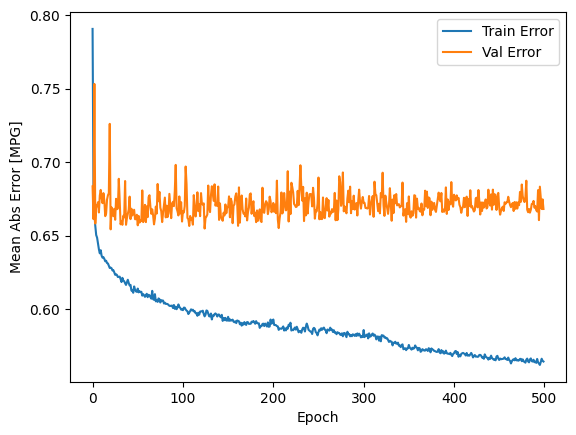

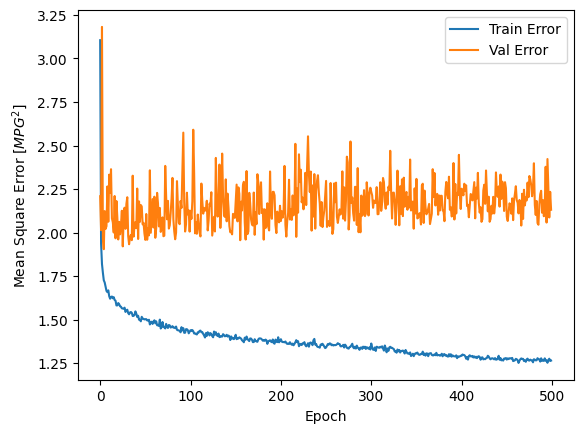

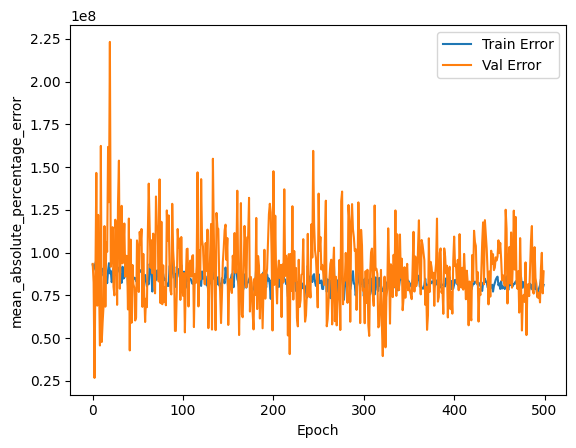

In [39]:
def plot_history(history):
  hist = pd.DataFrame(history.history)
  hist['epoch'] = history.epoch

  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Mean Abs Error [MPG]')
  plt.plot(hist['epoch'], hist['mae'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_mae'],
           label = 'Val Error')
  #plt.ylim([0,5])
  plt.legend()

  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Mean Square Error [$MPG^2$]')
  plt.plot(hist['epoch'], hist['mse'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_mse'],
           label = 'Val Error')
  #plt.ylim([0,20])
  plt.legend()
  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('mean_absolute_percentage_error')
  plt.plot(hist['epoch'], hist['mean_absolute_percentage_error'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_mean_absolute_percentage_error'],
           label = 'Val Error')
  #plt.ylim([0,20])
  plt.legend()
  plt.show()


plot_history(history)

In [40]:
from sklearn.metrics import mean_absolute_percentage_error,median_absolute_error
mae_train = median_absolute_error(
        Y_train,
        Y_train_pred,
    ).round(2)

mae_test = median_absolute_error(
        Y_test,
        Y_test_pred,
    ).round(2)

In [41]:
print("median absolute error")
print("entrenamiento:",mae_train,"validacion:",mae_test)

median absolute error
entrenamiento: 0.0 validacion: 0.0


In [42]:
from sklearn.metrics import mean_absolute_percentage_error,median_absolute_error
mape_train = mean_absolute_percentage_error(
        Y_train,
        Y_train_pred,
    ).round(2)

mape_test = mean_absolute_percentage_error(
        Y_test,
        Y_test_pred,
    ).round(2)

In [43]:
print("mean absolute percentage error")
print("entrenamiento:",mape_train,"validacion:",mape_test)

mean absolute percentage error
entrenamiento: 338146662034102.44 validacion: 400882802450748.4


In [44]:
resultTest=pd.DataFrame()
resultTest["esperado"]=Y_train
resultTest["predicho"]=Y_train_pred

In [45]:
resultTest.sample(10)

,esperado,predicho
46831,0.0,-0.000061
80687,0.0,-0.000061
142912,2.0,-0.000061
15575,2.0,1.169329
1670,0.0,1.002160
86256,1.0,1.111482
66076,2.0,1.002160
156847,0.0,-0.000061
71807,0.0,-0.000061
41082,0.0,-0.000061


In [46]:
from tensorflow.keras.models import load_model

#model.save('modelo-V3_1.h5')
#model=load_model('modelo-V3_1.h5')

# prediccion final 

creamos una dataframe nuevo para predecir las posibles accidentes en medellin y sus comunas en los años 2021 y 2022

In [47]:
test.columns
#84

Index(['CLASE_ACCIDENTE', 'NUMCOMUNA', 'CANTIDAD', 'DIA_FESTIVO', 't',
       'DIA_DE_LA_SEMANA', 'MES', 'DIA_DEL_MES'],
      dtype='object')

In [48]:
from datetime import datetime, timedelta
inicio = datetime(2021,1,1)
fin    = datetime(2022,12,31)

X_test_final = pd.DataFrame([inicio + timedelta(days=d) for d in range((fin - inicio).days + 1)],columns=["DIA"])
X_test_final

,DIA
0,2021-01-01
1,2021-01-02
2,2021-01-03
3,2021-01-04
4,2021-01-05
...,...
725,2022-12-27
726,2022-12-28
727,2022-12-29
728,2022-12-30


In [49]:
X_test_final["key"]=1
clase_accidente=pd.DataFrame(train.CLASE_ACCIDENTE.unique(),columns=["CLASE_ACCIDENTE"])
clase_accidente["key"]=1
X_test_final=pd.merge(X_test_final, clase_accidente, on ='key')
X_test_final.head(10)

,DIA,key,CLASE_ACCIDENTE
0,2021-01-01,1,caida ocupante
1,2021-01-01,1,choque
2,2021-01-01,1,otro
3,2021-01-01,1,atropello
4,2021-01-01,1,volcamiento
5,2021-01-01,1,incendio
6,2021-01-02,1,caida ocupante
7,2021-01-02,1,choque
8,2021-01-02,1,otro
9,2021-01-02,1,atropello


In [50]:
numcomuna=pd.DataFrame(train.NUMCOMUNA.unique(),columns=["NUMCOMUNA"])
numcomuna["key"]=1
X_test_final=pd.merge(X_test_final, numcomuna, on ='key').drop(["key"],axis=1)
X_test_final.head(10)

,DIA,CLASE_ACCIDENTE,NUMCOMUNA
0,2021-01-01,caida ocupante,10
1,2021-01-01,caida ocupante,2
2,2021-01-01,caida ocupante,1
3,2021-01-01,caida ocupante,15
4,2021-01-01,caida ocupante,14
5,2021-01-01,caida ocupante,11
6,2021-01-01,caida ocupante,7
7,2021-01-01,caida ocupante,6
8,2021-01-01,caida ocupante,4
9,2021-01-01,caida ocupante,9


In [51]:
#dia_festivo 1 si 0 no
X_test_final["dia_festivo".upper()]=X_test_final["DIA"].apply(lambda x : str(co.is_holiday_date(x)))
#tiempo en meses desde el primer data conocido 
X_test_final["t"]=X_test_final["DIA"].apply(lambda x : (pd.Timestamp(x).year-2014)*12+pd.Timestamp(x).month-7)
#dia de la semana en numero
X_test_final["dia_de_la_semana".upper()]=X_test_final["dia".upper()].apply(lambda x : str(pd.Timestamp(x).day_of_week))
#mes de ocurencia
X_test_final["MES"]=X_test_final["DIA"].apply(lambda x : str(pd.Timestamp(x).month))
#dia que ocurrio el accidente en el mes
X_test_final["dia_del_mes".upper()]=X_test_final["dia".upper()].apply(lambda x :str( pd.Timestamp(x).day))
X_test_final.drop(["DIA"],axis=1,inplace=True)
X_test_final

,CLASE_ACCIDENTE,NUMCOMUNA,DIA_FESTIVO,t,DIA_DE_LA_SEMANA,MES,DIA_DEL_MES
0,caida ocupante,10,True,78,4,1,1
1,caida ocupante,2,True,78,4,1,1
2,caida ocupante,1,True,78,4,1,1
3,caida ocupante,15,True,78,4,1,1
4,caida ocupante,14,True,78,4,1,1
...,...,...,...,...,...,...,...
70075,incendio,8,False,101,5,12,31
70076,incendio,13,False,101,5,12,31
70077,incendio,16,False,101,5,12,31
70078,incendio,3,False,101,5,12,31


aplicamos onehot encode al nuevo dataframe

In [52]:
X_test_final=pd.get_dummies(X_test_final,drop_first=True)
X_test_final.columns

Index(['t', 'CLASE_ACCIDENTE_caida ocupante', 'CLASE_ACCIDENTE_choque',
       'CLASE_ACCIDENTE_incendio', 'CLASE_ACCIDENTE_otro',
       'CLASE_ACCIDENTE_volcamiento', 'NUMCOMUNA_10', 'NUMCOMUNA_11',
       'NUMCOMUNA_12', 'NUMCOMUNA_13', 'NUMCOMUNA_14', 'NUMCOMUNA_15',
       'NUMCOMUNA_16', 'NUMCOMUNA_2', 'NUMCOMUNA_3', 'NUMCOMUNA_4',
       'NUMCOMUNA_5', 'NUMCOMUNA_6', 'NUMCOMUNA_7', 'NUMCOMUNA_8',
       'NUMCOMUNA_9', 'DIA_FESTIVO_True', 'DIA_DE_LA_SEMANA_1',
       'DIA_DE_LA_SEMANA_2', 'DIA_DE_LA_SEMANA_3', 'DIA_DE_LA_SEMANA_4',
       'DIA_DE_LA_SEMANA_5', 'DIA_DE_LA_SEMANA_6', 'MES_10', 'MES_11',
       'MES_12', 'MES_2', 'MES_3', 'MES_4', 'MES_5', 'MES_6', 'MES_7', 'MES_8',
       'MES_9', 'DIA_DEL_MES_10', 'DIA_DEL_MES_11', 'DIA_DEL_MES_12',
       'DIA_DEL_MES_13', 'DIA_DEL_MES_14', 'DIA_DEL_MES_15', 'DIA_DEL_MES_16',
       'DIA_DEL_MES_17', 'DIA_DEL_MES_18', 'DIA_DEL_MES_19', 'DIA_DEL_MES_2',
       'DIA_DEL_MES_20', 'DIA_DEL_MES_21', 'DIA_DEL_MES_22', 'DIA_DEL_MES_23',

In [53]:
prediccion_final=pd.DataFrame(model.predict(X_test_final))
prediccion_final

,0
0,-0.000061
1,-0.000061
2,-0.000061
3,-0.000061
4,-0.000061
...,...
70075,-0.000061
70076,-0.000061
70077,-0.000061
70078,-0.000061


# analisis de los resultados

In [54]:
datos=pd.concat([X_train[:],X_test[:],X_test_final], ignore_index=True)

datos.shape

(286176, 69)

In [55]:
resultados=pd.concat([pd.DataFrame(Y_train_pred),pd.DataFrame(Y_test_pred),prediccion_final], ignore_index=True)
resultados.shape

(286176, 1)

In [56]:
print(len(X_train)+len(X_test),len(X_test_final))
print(len(pd.DataFrame(Y_train_pred)),len(pd.DataFrame(Y_test_pred)),len(prediccion_final))

216096 70080
157632 58464 70080


In [57]:
print(X_train.shape,X_test.shape,X_test_final.shape)

(157632, 69) (58464, 69) (70080, 69)
